In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from constants import SPECIES
import cv2
from keras.models import Model
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Dropout,
    Dense,
    Input,
    concatenate,
    GlobalAveragePooling2D,
    AveragePooling2D,
    Flatten,
)
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import math
import keras

In [3]:
# import the images from the folder
test = []
train = []
for species in SPECIES:
    for file in os.listdir("img/Test/" + species):
        test.append([file, species])
    for file in os.listdir("img/Train/" + species):
        train.append([file, species])

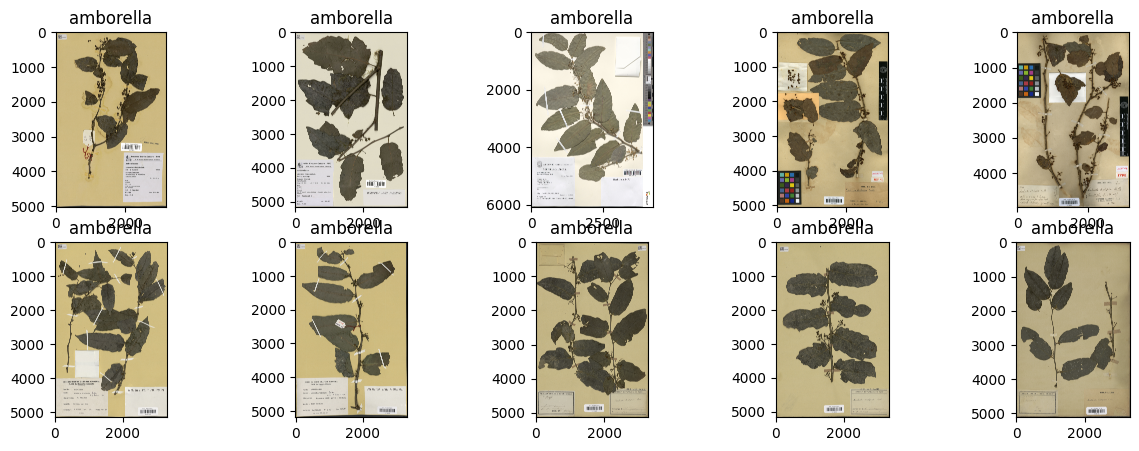

In [4]:
# plot the first 5 images of the training set and test set
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    img = plt.imread("img/Train/" + train[i][1] + "/" + train[i][0])
    ax[0, i].imshow(img)
    ax[0, i].set_title(train[i][1])
    img = plt.imread("img/Test/" + test[i][1] + "/" + test[i][0])
    ax[1, i].imshow(img)
    ax[1, i].set_title(test[i][1])
plt.show()

In [5]:
# remove the background of the images
def remove_background(img):
    colored_image = cv2.imread(img)
    grey_image = cv2.cvtColor(colored_image, cv2.COLOR_RGB2GRAY)
    for _ in range(3):
        grey_image = cv2.GaussianBlur(grey_image, (51, 51), 0)
    _, thresh = cv2.threshold(grey_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Apply mask to colored_image
    colored_image = cv2.bitwise_or(
        colored_image, colored_image, mask=cv2.bitwise_not(thresh)
    )
    return colored_image

In [6]:
# for each image in the training set, remove the background
for i in range(len(train)):
    img = remove_background("img/Train/" + train[i][1] + "/" + train[i][0])
    cv2.imwrite("img/Train background/" + train[i][1] + "/" + train[i][0], img)

# for each image in the test set, remove the background
for i in range(len(test)):
    img = remove_background("img/Test/" + test[i][1] + "/" + test[i][0])
    cv2.imwrite("img/Test background/" + test[i][1] + "/" + test[i][0], img)

In [7]:
# for each image, randomly create 6 224x224 crops
def crop(img, n, size):
    crops = []
    for i in range(n):
        x = np.random.randint(0, img.shape[0] - size)
        y = np.random.randint(0, img.shape[1] - size)
        crops.append(img[x : x + size, y : y + size, :])
    return crops

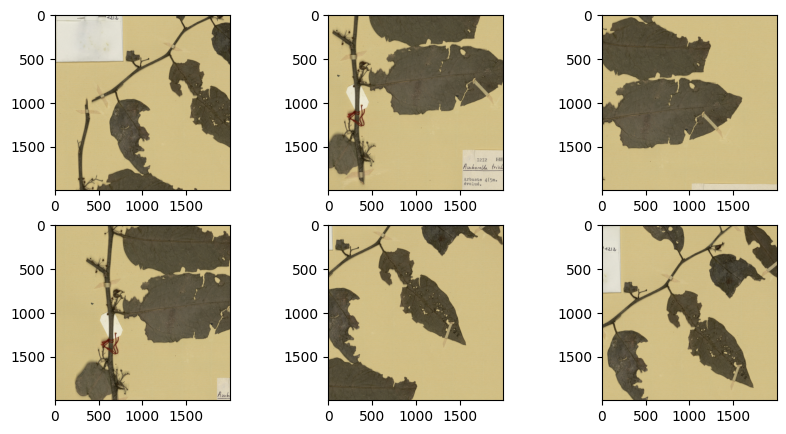

In [8]:
# test the crop function
img = plt.imread("img/Train/" + train[5][1] + "/" + train[5][0])
crops = crop(img, 6, 2000)
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
for i in range(3):
    ax[0, i].imshow(crops[i])
    ax[1, i].imshow(crops[i + 3])
plt.show()

In [23]:
# create the training set
X_train = []
y_train = []
for i in range(len(train)):
    img_bg = plt.imread("img/Train background/" + train[i][1] + "/" + train[i][0])
    img = plt.imread("img/Train/" + train[i][1] + "/" + train[i][0])
    crops_bg = crop(img_bg, 6, 2000)
    crops = crop(img, 6, 2000)
    for j in range(6):
        X_train.append(crops_bg[j])
        y_train.append(train[i][1])
        X_train.append(crops[j])
        y_train.append(train[i][1])

In [24]:
# create the test set
X_test = []
y_test = []
for i in range(len(test)):
    img = plt.imread("img/Test/" + test[i][1] + "/" + test[i][0])
    X_test.append(img)
    y_test.append(test[i][1])

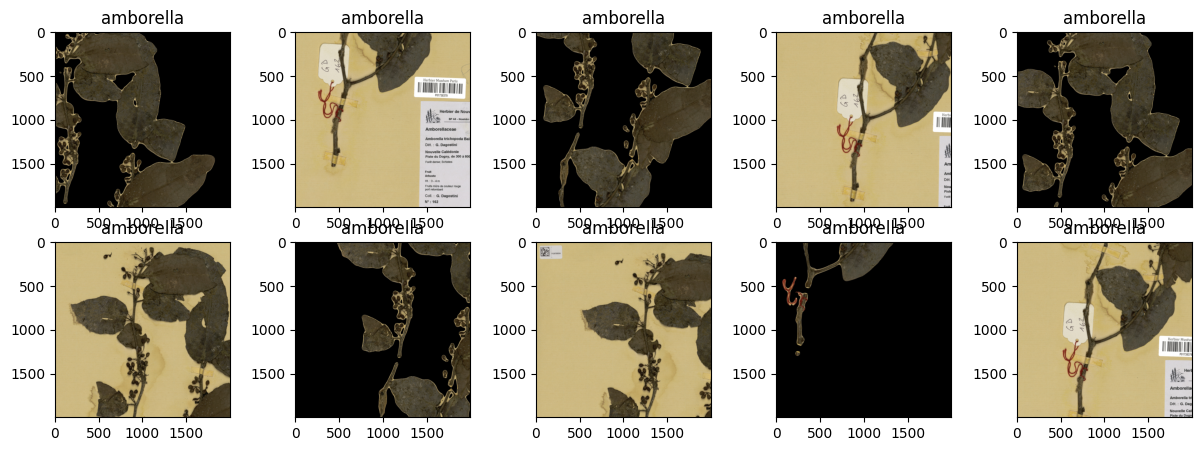

In [11]:
# display the first 10 images of the training set
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0, i].imshow(X_train[i])
    ax[0, i].set_title(y_train[i])
    ax[1, i].imshow(X_train[i + 5])
    ax[1, i].set_title(y_train[i + 5])
plt.show()

In [13]:
# shape of the training set
print(len(X_train))

2640


In [25]:
# resize the images to 224x224
X_train = [cv2.resize(img, (224, 224)) for img in X_train]

In [26]:
# shuffle the training set
X_train, y_train = np.array(X_train), np.array(y_train)
idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[idx], y_train[idx]

In [27]:
# take 10% of the training set as validation set
X_train_source = X_train
X_val = X_train_source[: int(len(X_train_source) * 0.1)]
y_val = y_train[: int(len(X_train_source) * 0.1)]
X_train = X_train_source[int(len(X_train_source) * 0.1) :]
y_train = y_train[int(len(X_train_source) * 0.1) :]

In [28]:
num_classes = len(SPECIES)

# one-hot encode the labels
SPECIES_TO_NUM = {species: i for i, species in enumerate(SPECIES)}

In [29]:
y_train = np_utils.to_categorical(
    [SPECIES_TO_NUM[species] for species in y_train], num_classes
)
y_val = np_utils.to_categorical(
    [SPECIES_TO_NUM[species] for species in y_val], num_classes
)

In [30]:
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

# normalize the images
X_train /= 255
X_val /= 255

In [20]:
# transform the data into np arrays
#X_train = np.array(X_train)
#X_val = np.array(X_val)
#y_train = np.array(y_train)
#y_val = np.array(y_val)

In [31]:
def inception_module(
    x,
    filters_1x1,
    filters_3x3_reduce,
    filters_3x3,
    filters_5x5_reduce,
    filters_5x5,
    filters_pool_proj,
    name=None,
):

    conv_1x1 = Conv2D(
        filters_1x1,
        (1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x)

    conv_3x3 = Conv2D(
        filters_3x3_reduce,
        (1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x)
    conv_3x3 = Conv2D(
        filters_3x3,
        (3, 3),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(conv_3x3)
    conv_5x5 = Conv2D(
        filters_5x5_reduce,
        (1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(x)
    conv_5x5 = Conv2D(
        filters_5x5,
        (5, 5),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(conv_5x5)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding="same")(x)
    pool_proj = Conv2D(
        filters_pool_proj,
        (1, 1),
        padding="same",
        activation="relu",
        kernel_initializer=kernel_init,
        bias_initializer=bias_init,
    )(pool_proj)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output


kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [35]:
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(
    64,
    (7, 7),
    padding="same",
    strides=(2, 2),
    activation="relu",
    name="conv_1_7x7/2",
    kernel_initializer=kernel_init,
    bias_initializer=bias_init,
)(input_layer)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_1_3x3/2")(x)
x = Conv2D(
    64, (1, 1), padding="same", strides=(1, 1), activation="relu", name="conv_2a_3x3/1"
)(x)
x = Conv2D(
    192, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv_2b_3x3/1"
)(x)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_2_3x3/2")(x)
x = inception_module(
    x,
    filters_1x1=64,
    filters_3x3_reduce=96,
    filters_3x3=128,
    filters_5x5_reduce=16,
    filters_5x5=32,
    filters_pool_proj=32,
    name="inception_3a",
)
x = inception_module(
    x,
    filters_1x1=128,
    filters_3x3_reduce=128,
    filters_3x3=192,
    filters_5x5_reduce=32,
    filters_5x5=96,
    filters_pool_proj=64,
    name="inception_3b",
)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_3_3x3/2")(x)
x = inception_module(
    x,
    filters_1x1=192,
    filters_3x3_reduce=96,
    filters_3x3=208,
    filters_5x5_reduce=16,
    filters_5x5=48,
    filters_pool_proj=64,
    name="inception_4a",
)


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding="same", activation="relu")(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation="relu")(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(11, activation="softmax", name="auxilliary_output_1")(x1)

x = inception_module(
    x,
    filters_1x1=160,
    filters_3x3_reduce=112,
    filters_3x3=224,
    filters_5x5_reduce=24,
    filters_5x5=64,
    filters_pool_proj=64,
    name="inception_4b",
)
x = inception_module(
    x,
    filters_1x1=128,
    filters_3x3_reduce=128,
    filters_3x3=256,
    filters_5x5_reduce=24,
    filters_5x5=64,
    filters_pool_proj=64,
    name="inception_4c",
)
x = inception_module(
    x,
    filters_1x1=112,
    filters_3x3_reduce=144,
    filters_3x3=288,
    filters_5x5_reduce=32,
    filters_5x5=64,
    filters_pool_proj=64,
    name="inception_4d",
)

x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding="same", activation="relu")(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation="relu")(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(11, activation="softmax", name="auxilliary_output_2")(x2)

x = inception_module(
    x,
    filters_1x1=256,
    filters_3x3_reduce=160,
    filters_3x3=320,
    filters_5x5_reduce=32,
    filters_5x5=128,
    filters_pool_proj=128,
    name="inception_4e",
)
x = MaxPool2D((3, 3), padding="same", strides=(2, 2), name="max_pool_4_3x3/2")(x)
x = inception_module(
    x,
    filters_1x1=256,
    filters_3x3_reduce=160,
    filters_3x3=320,
    filters_5x5_reduce=32,
    filters_5x5=128,
    filters_pool_proj=128,
    name="inception_5a",
)
x = inception_module(
    x,
    filters_1x1=384,
    filters_3x3_reduce=192,
    filters_3x3=384,
    filters_5x5_reduce=48,
    filters_5x5=128,
    filters_pool_proj=128,
    name="inception_5b",
)
x = GlobalAveragePooling2D(name="avg_pool_5_3x3/1")(x)
x = Dropout(0.4)(x)
x = Dense(11, activation="softmax", name="output")(x)
model = Model(input_layer, [x, x1, x2], name="inception_v1")

In [36]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [37]:
epochs = 15
initial_rate = 0.01


def decay(epoch, steps=100):
    initial_rate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_rate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate


sgd = SGD(learning_rate=initial_rate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(
    loss=[
        "categorical_crossentropy",
        "categorical_crossentropy",
        "categorical_crossentropy",
    ],
    loss_weights=[1, 0.3, 0.3],
    optimizer=sgd,
    metrics=["accuracy"],
)

In [38]:
history = model.fit(X_train, [y_train, y_train, y_train], 
                    validation_data=(X_test, [y_test, y_test, y_test]),
                    epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/15


2022-12-05 18:51:13.601579: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 18:51:15.786251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 4.0988 - output_loss: 2.5828 - auxilliary_output_1_loss: 2.5139 - auxilliary_output_2_loss: 2.5395 - output_accuracy: 0.0922 - auxilliary_output_1_accuracy: 0.0795 - auxilliary_output_2_accuracy: 0.0909

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'str\'>"})'})